In [ ]:
# Install catalax
# !pip install catalax

In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import catalax as ctx
import catalax.neural as cnn
import catalax.mcmc as cmc

ctx.set_host_count(10)

## Universal Ordinary Differential Equations

Universal ODEs are a class of ODEs which combine the power of conventional ODE modelling and neural networks. The idea is to merge both the existing theory (ODE system) and those things we dont know yet (data-integrated). Here, we will explore the use of universal ODEs for modelling the dynamics of an enzyme kinetic.

### Procedure

1. Generate data for the true underling system --> Competitive substrate inhibition
2. Fit a regular Michaelis-Menten model to the data
3. Fit a universal ODE to the data and investigate the ANN correction over time


## 1. Generate $y_{true}$ data

We will generate data for a competitive substrate inhibition system. The system is governed by the following equation:

$$\frac{dS}{dt} = \frac{- v_{ max } * s_0 }{ K_m + s_0 * (1 + \frac{ s_0 }{ K_i }) }$$

where $v_{max}$ is the maximum velocity, $K_m$ is the Michaelis constant and $K_i$ is the inhibition constant.


In [2]:
model = ctx.Model(name="Universal ODE Example")

# Add species
model.add_species(s0="Substrate")

# Set ODE equations
model.add_ode("s0", "-v_max * s0 / ( K_m + s0 * ( 1 + s0 / K_i ) )")

# Set parameter values
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 200.0
model.parameters.K_i.value = 137.0

model

Model summary


Eq(x, Matrix([[s0]]))

Eq(theta, Matrix([[K_i, K_m, v_max]]))

Eq(Derivative(Substrate, t), -s0*v_max/(K_m + s0*(1 + s0/K_i)))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_i,K_i,137.0,False,None,None,None,None
1,K_m,K_m,200.0,False,None,None,None,None
2,v_max,v_max,7.0,False,None,None,None,None


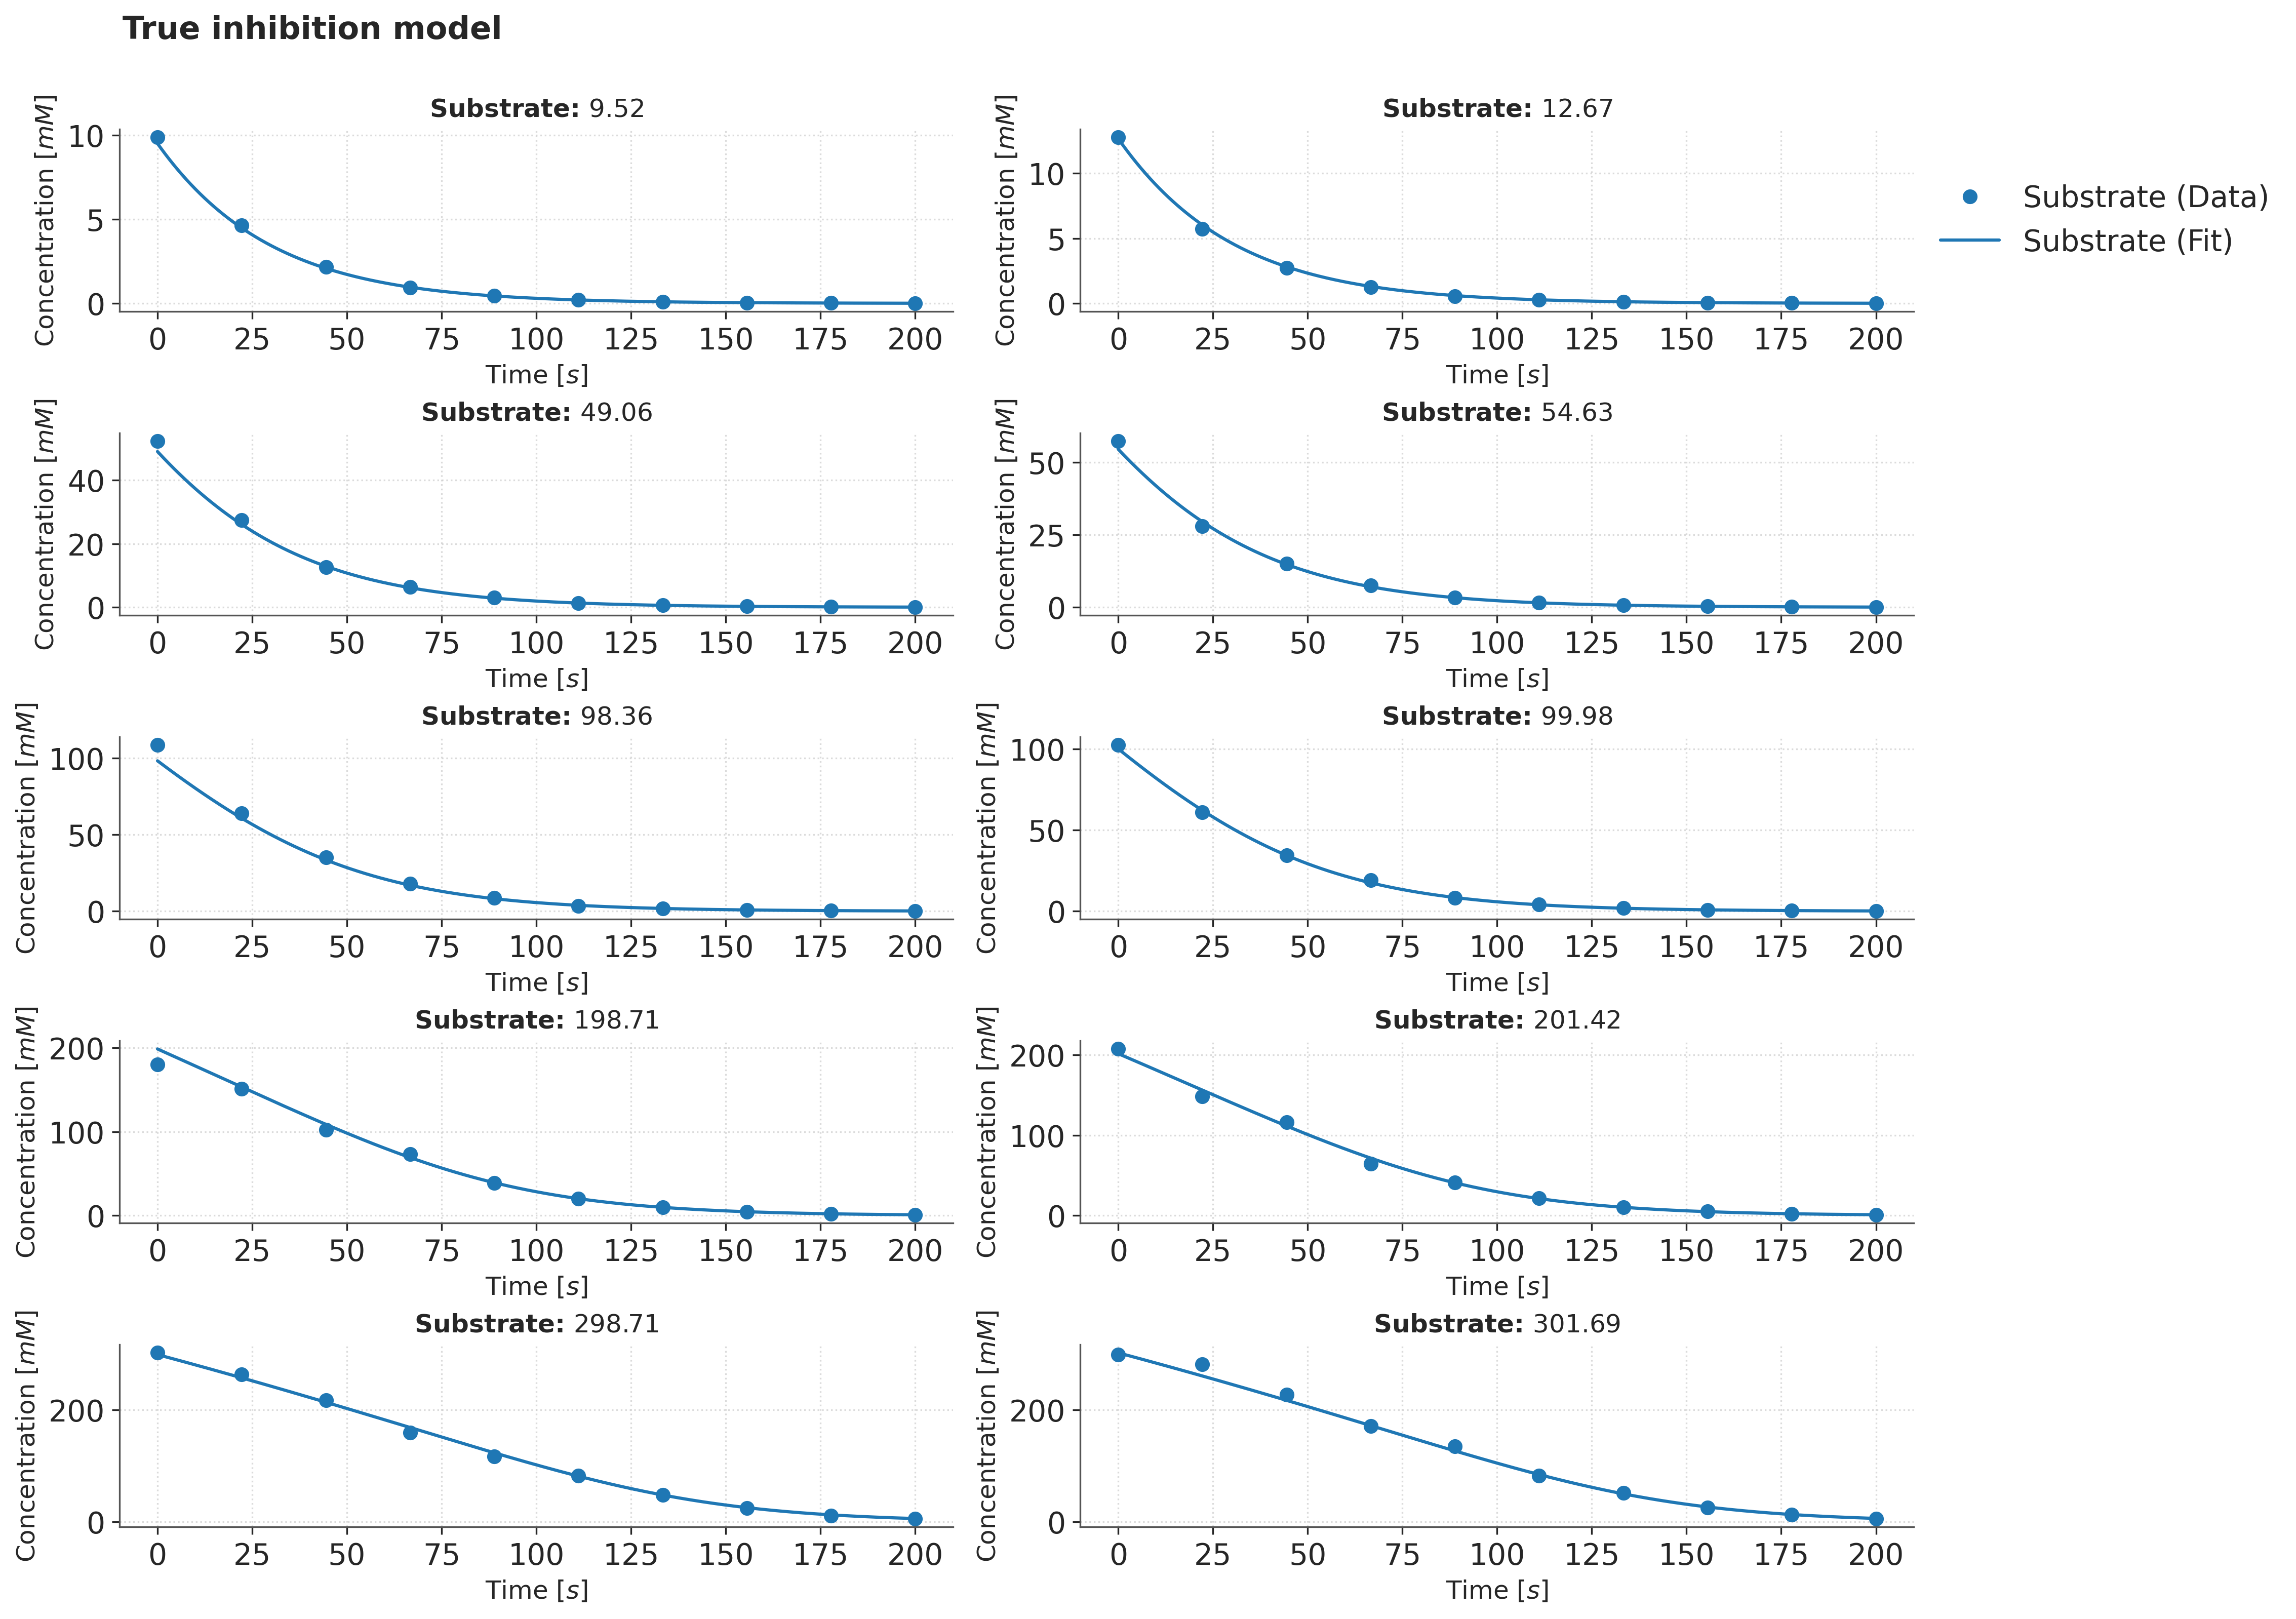

In [3]:
# Simulate for multiple initial conditions
n_replicates = 2
sigma = 2.0
initial_conditions = sorted(
    [
        {"s0": np.random.normal(value, sigma)}
        for value in [10.0, 50.0, 100.0, 200.0, 300.0] * n_replicates
    ],
    key=lambda x: x["s0"],
)

# Integrate the ODEs
time, states = model.simulate(
    t0=0.0,
    t1=200.0,
    nsteps=10,
    initial_conditions=initial_conditions,
    in_axes=ctx.INITS,
)

# Save trajectories, times and initial conditions
y0s = model._assemble_y0_array(initial_conditions, ctx.INITS)
times = jnp.stack([time] * len(initial_conditions), axis=0)
data = states + np.random.normal(0, 0.05, states.shape) * states

# Visualize the results
f = ctx.visualize(
    model=model,
    data=data,
    times=jnp.stack([time] * len(initial_conditions), axis=0),
    initial_conditions=initial_conditions,
    figsize=(3, 5),
    title="True inhibition model",
)

## 2. Fit a regular Michaelis-Menten model to the data

Next we will fit a regular Michaelis-Menten model to the data. The model is given by:

$$\frac{dS}{dt} = \frac{- v_{ max } * s_0 }{ K_m + s_0 }$$

where $v_{max}$ is the maximum velocity and $K_m$ is the Michaelis constant.


In [4]:
# Create the model
model = ctx.Model(name="Michaelis Menten Example")
model.add_species(s0="Substrate")
model.add_ode("s0", "-v_max * s0 / ( K_m + s0 )")

# Define priors
model.parameters.v_max.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.K_m.prior = cmc.priors.Uniform(low=1e-6, high=1000.0)

# Sample from posterior
result, bayes = cmc.run_mcmc(
    model=model,
    data=data,
    times=times,
    initial_conditions=initial_conditions,
    num_warmup=1000,
    num_samples=10000,
    num_chains=4,
    chain_method="parallel",
    yerrs=2.0,
)

🔸 Priors
├── K_m: U(low=1e-06, high=1000.0)
├── v_max: U(low=1e-06, high=200.0)

🚀 Running MCMC



  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]



🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m     39.22      4.26     39.08     32.16     46.12  33304.44      1.00
     sigma      5.15      0.35      5.13      4.58      5.72  31582.69      1.00
     v_max      2.38      0.06      2.38      2.28      2.48  33687.16      1.00

Number of divergences: 0


/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


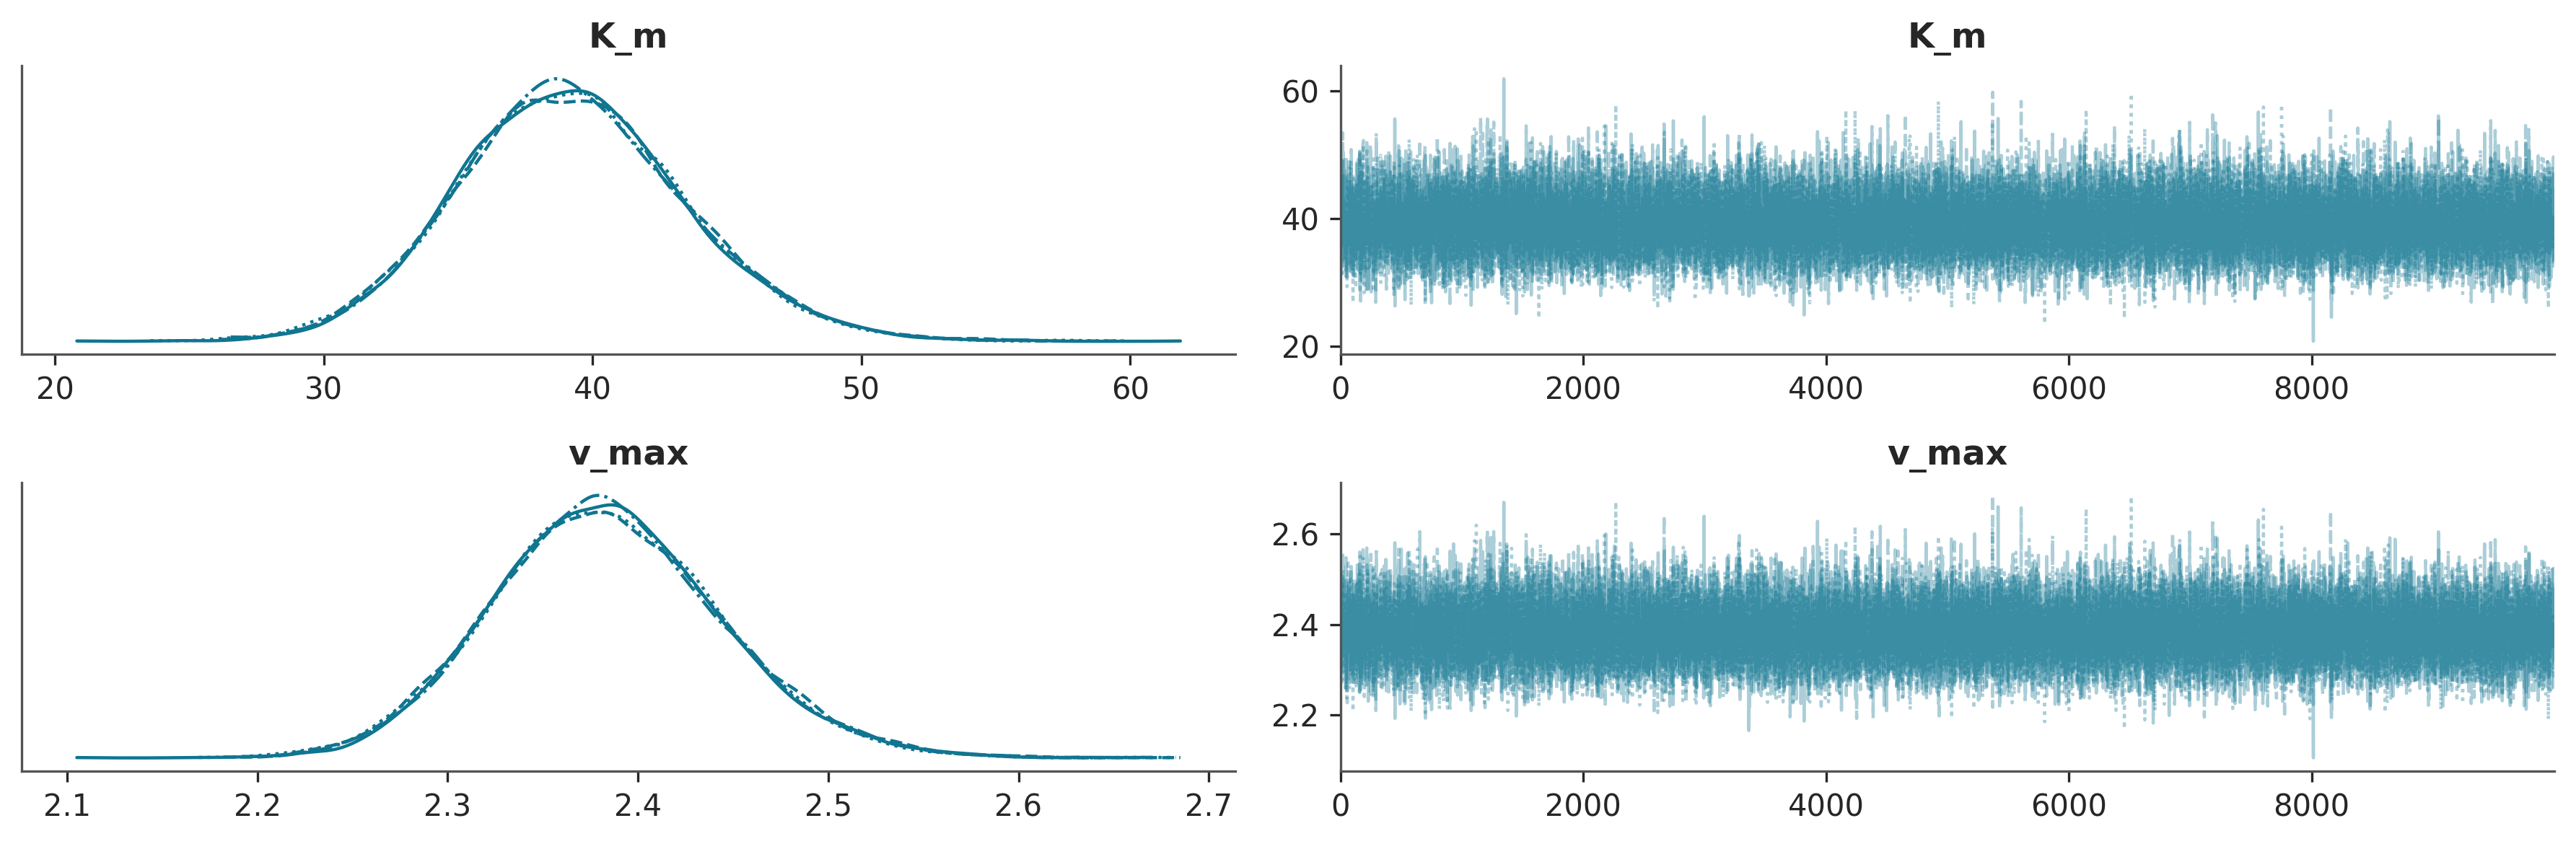

In [5]:
# Check the results
f = cmc.plot_trace(result, model)

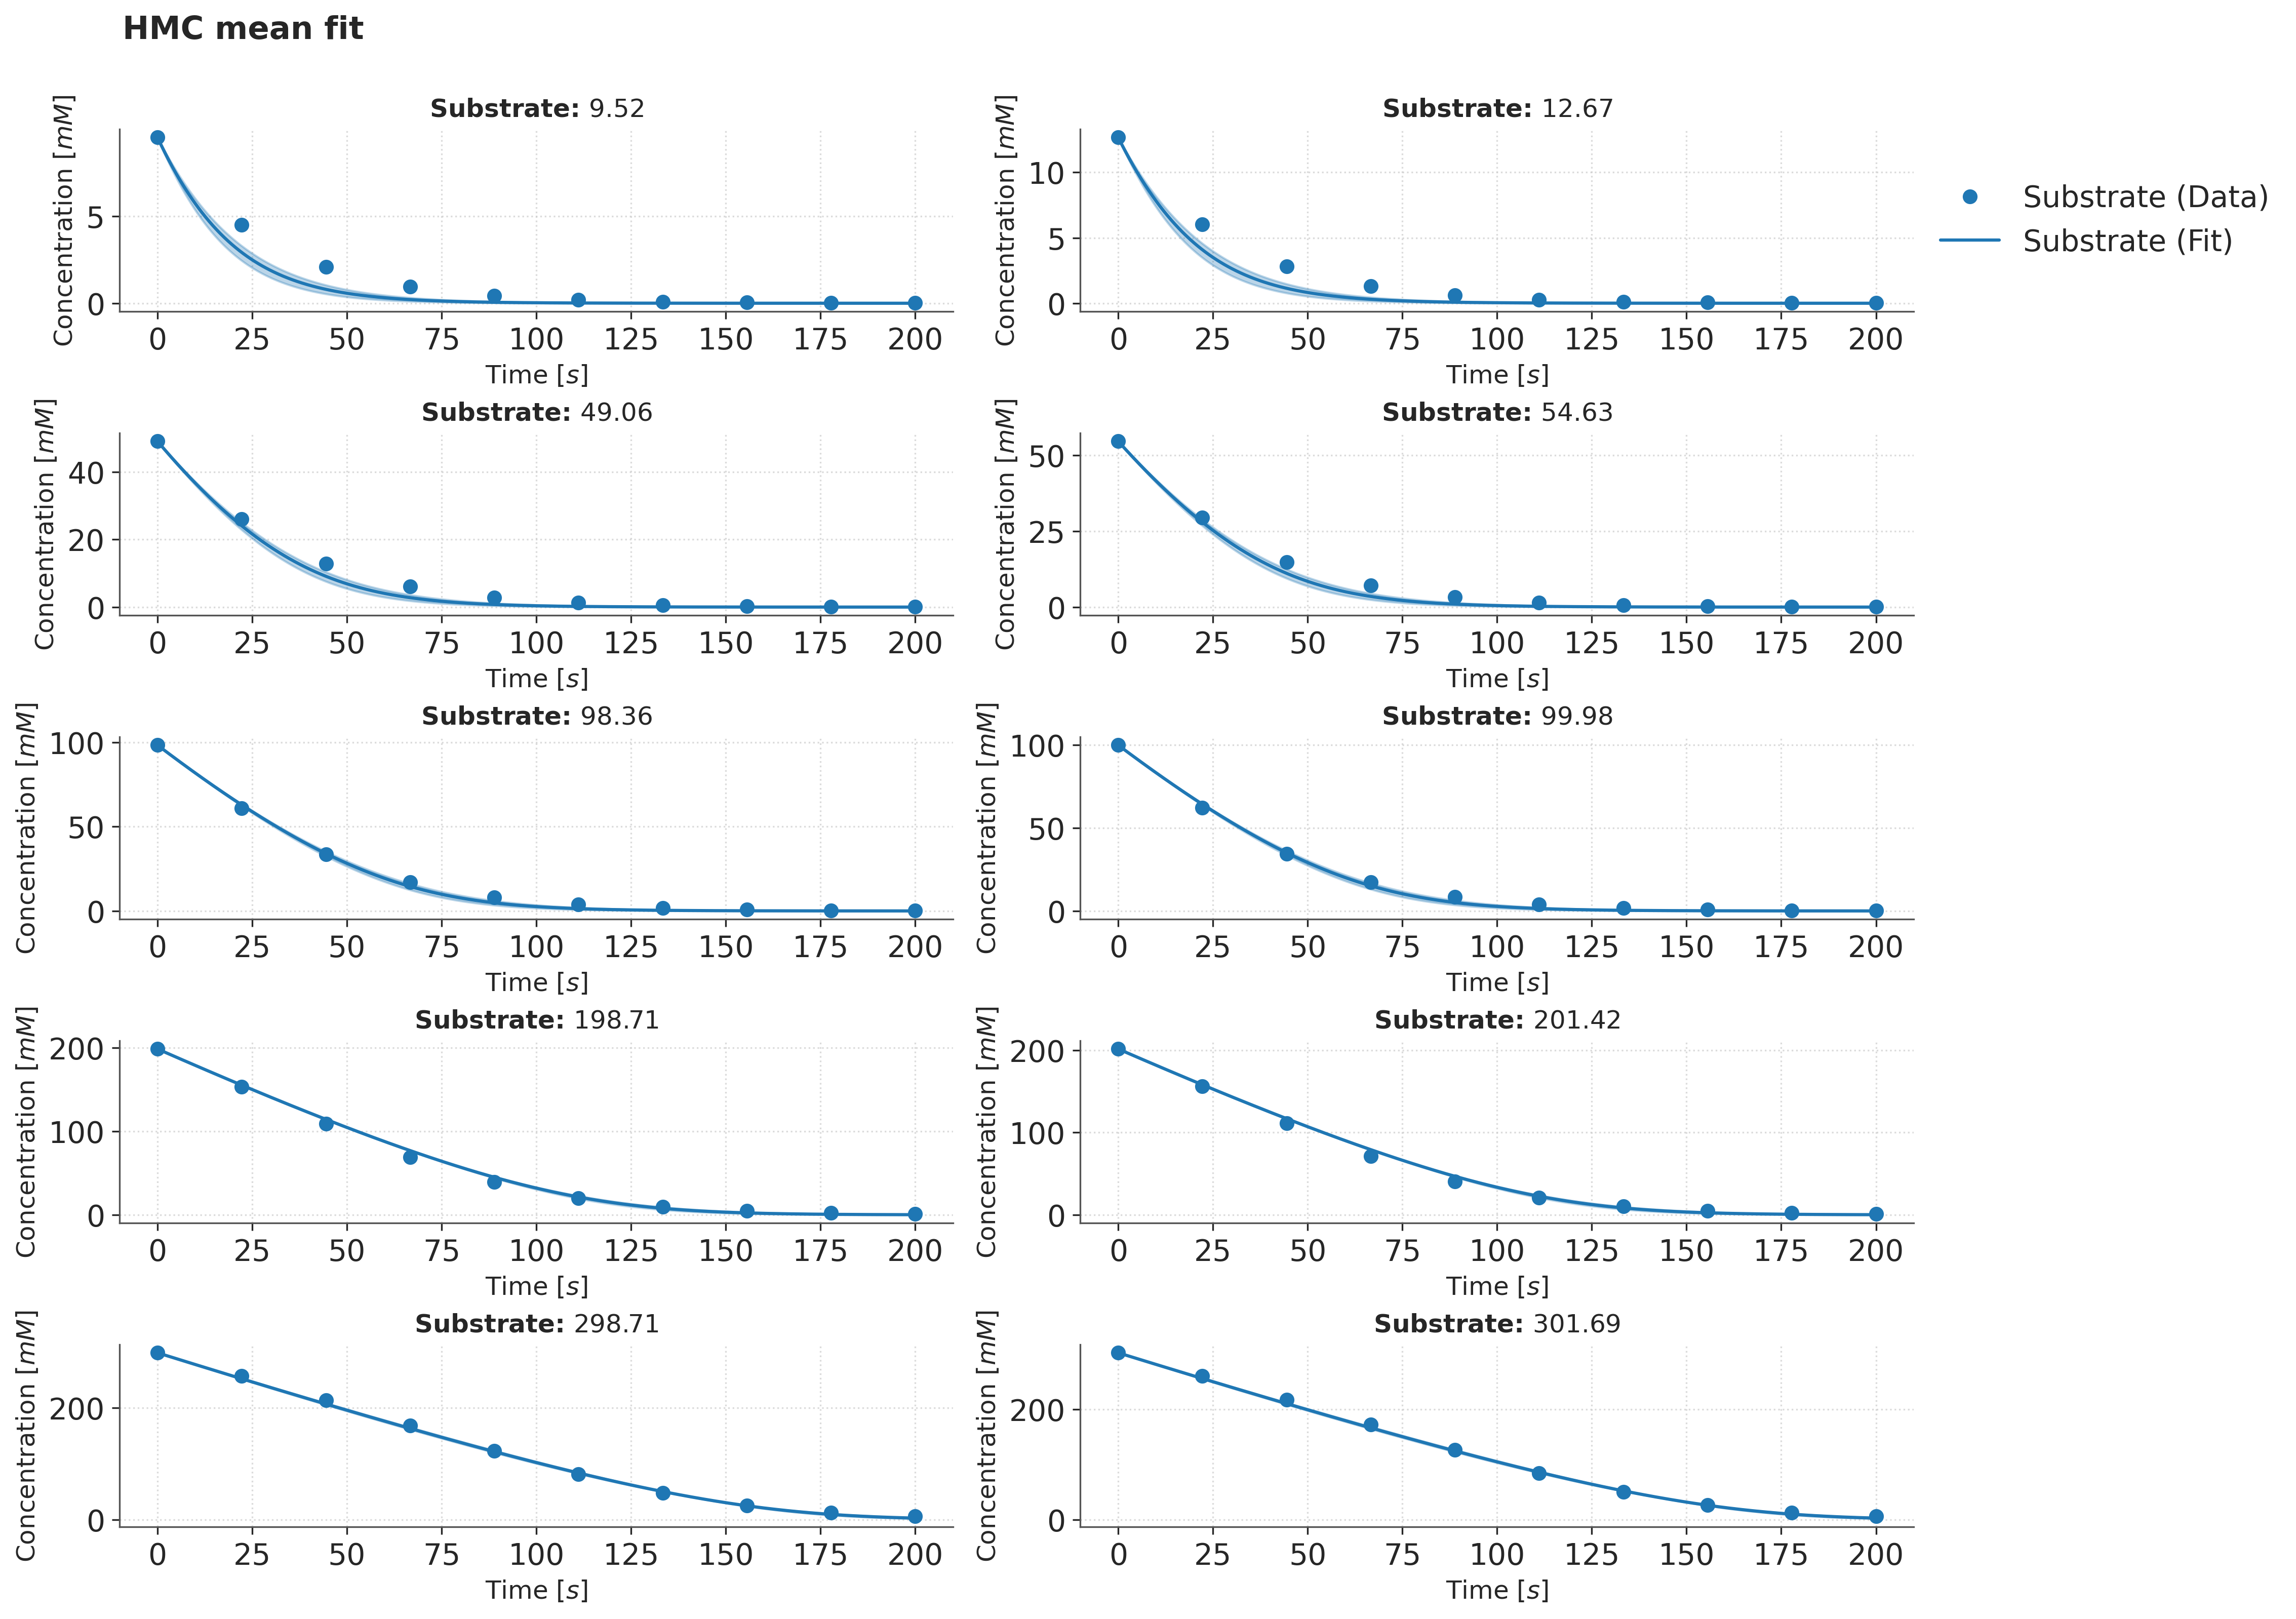

In [6]:
# Add mean parameter values to the model
model.parameters.v_max.value = result.get_samples()["v_max"].mean()
model.parameters.K_m.value = result.get_samples()["K_m"].mean()

f = ctx.visualize(
    model=model,
    data=states,
    mcmc=result,
    times=jnp.stack([time] * len(initial_conditions), axis=0),
    initial_conditions=initial_conditions,
    figsize=(3, 5),
    title="HMC mean fit",
)

## 3. Fit a universal ODE to the data

We observe that the regular Michaelis-Menten model is not able to capture the dynamics of the system in low substrate concentrations. We will now fit a universal ODE to the data such that the neural network will balance the dynamics of the system.


In [7]:
# Define the universal ODE
rbf = cnn.RBFLayer(0.1)
universal_ode = cnn.UniversalODE.from_model(
    model=model,
    width_size=3,
    depth=3,
    activation=rbf,
)

# Construct a strategy
strategy = cnn.Strategy()
strategy.add_step(lr=1e-2, steps=200, batch_size=20, length=0.1, train=cnn.Modes.MLP)
strategy.add_step(lr=1e-2, steps=1000, batch_size=20, train=cnn.Modes.BOTH)
strategy.add_step(lr=1e-3, steps=1000, batch_size=20, train=cnn.Modes.BOTH)

# Train the universal ODE
trained = cnn.train_neural_ode(
    model=universal_ode,
    data=data,
    times=times,
    inital_conditions=y0s,
    n_augmentations=10,
    sigma=0.05,
    strategy=strategy,
    print_every=10,
)


🚀 Training UniversalODE...

🔸 Step #1
├── lr: 0.01
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.0
├── train: mlp
│


╰── loss: 33.8170 mae: 5.6594: : 210it [00:09, 21.62it/s]                       




🔸 Step #2
├── lr: 0.01
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.0
├── train: both
│


╰── loss: 8.7112 mae: 2.1370: : 1010it [00:13, 74.36it/s]                         




🔸 Step #3
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.0
├── train: both
│


╰── loss: 6.4936 mae: 1.6996: : 1010it [00:08, 115.48it/s]                        

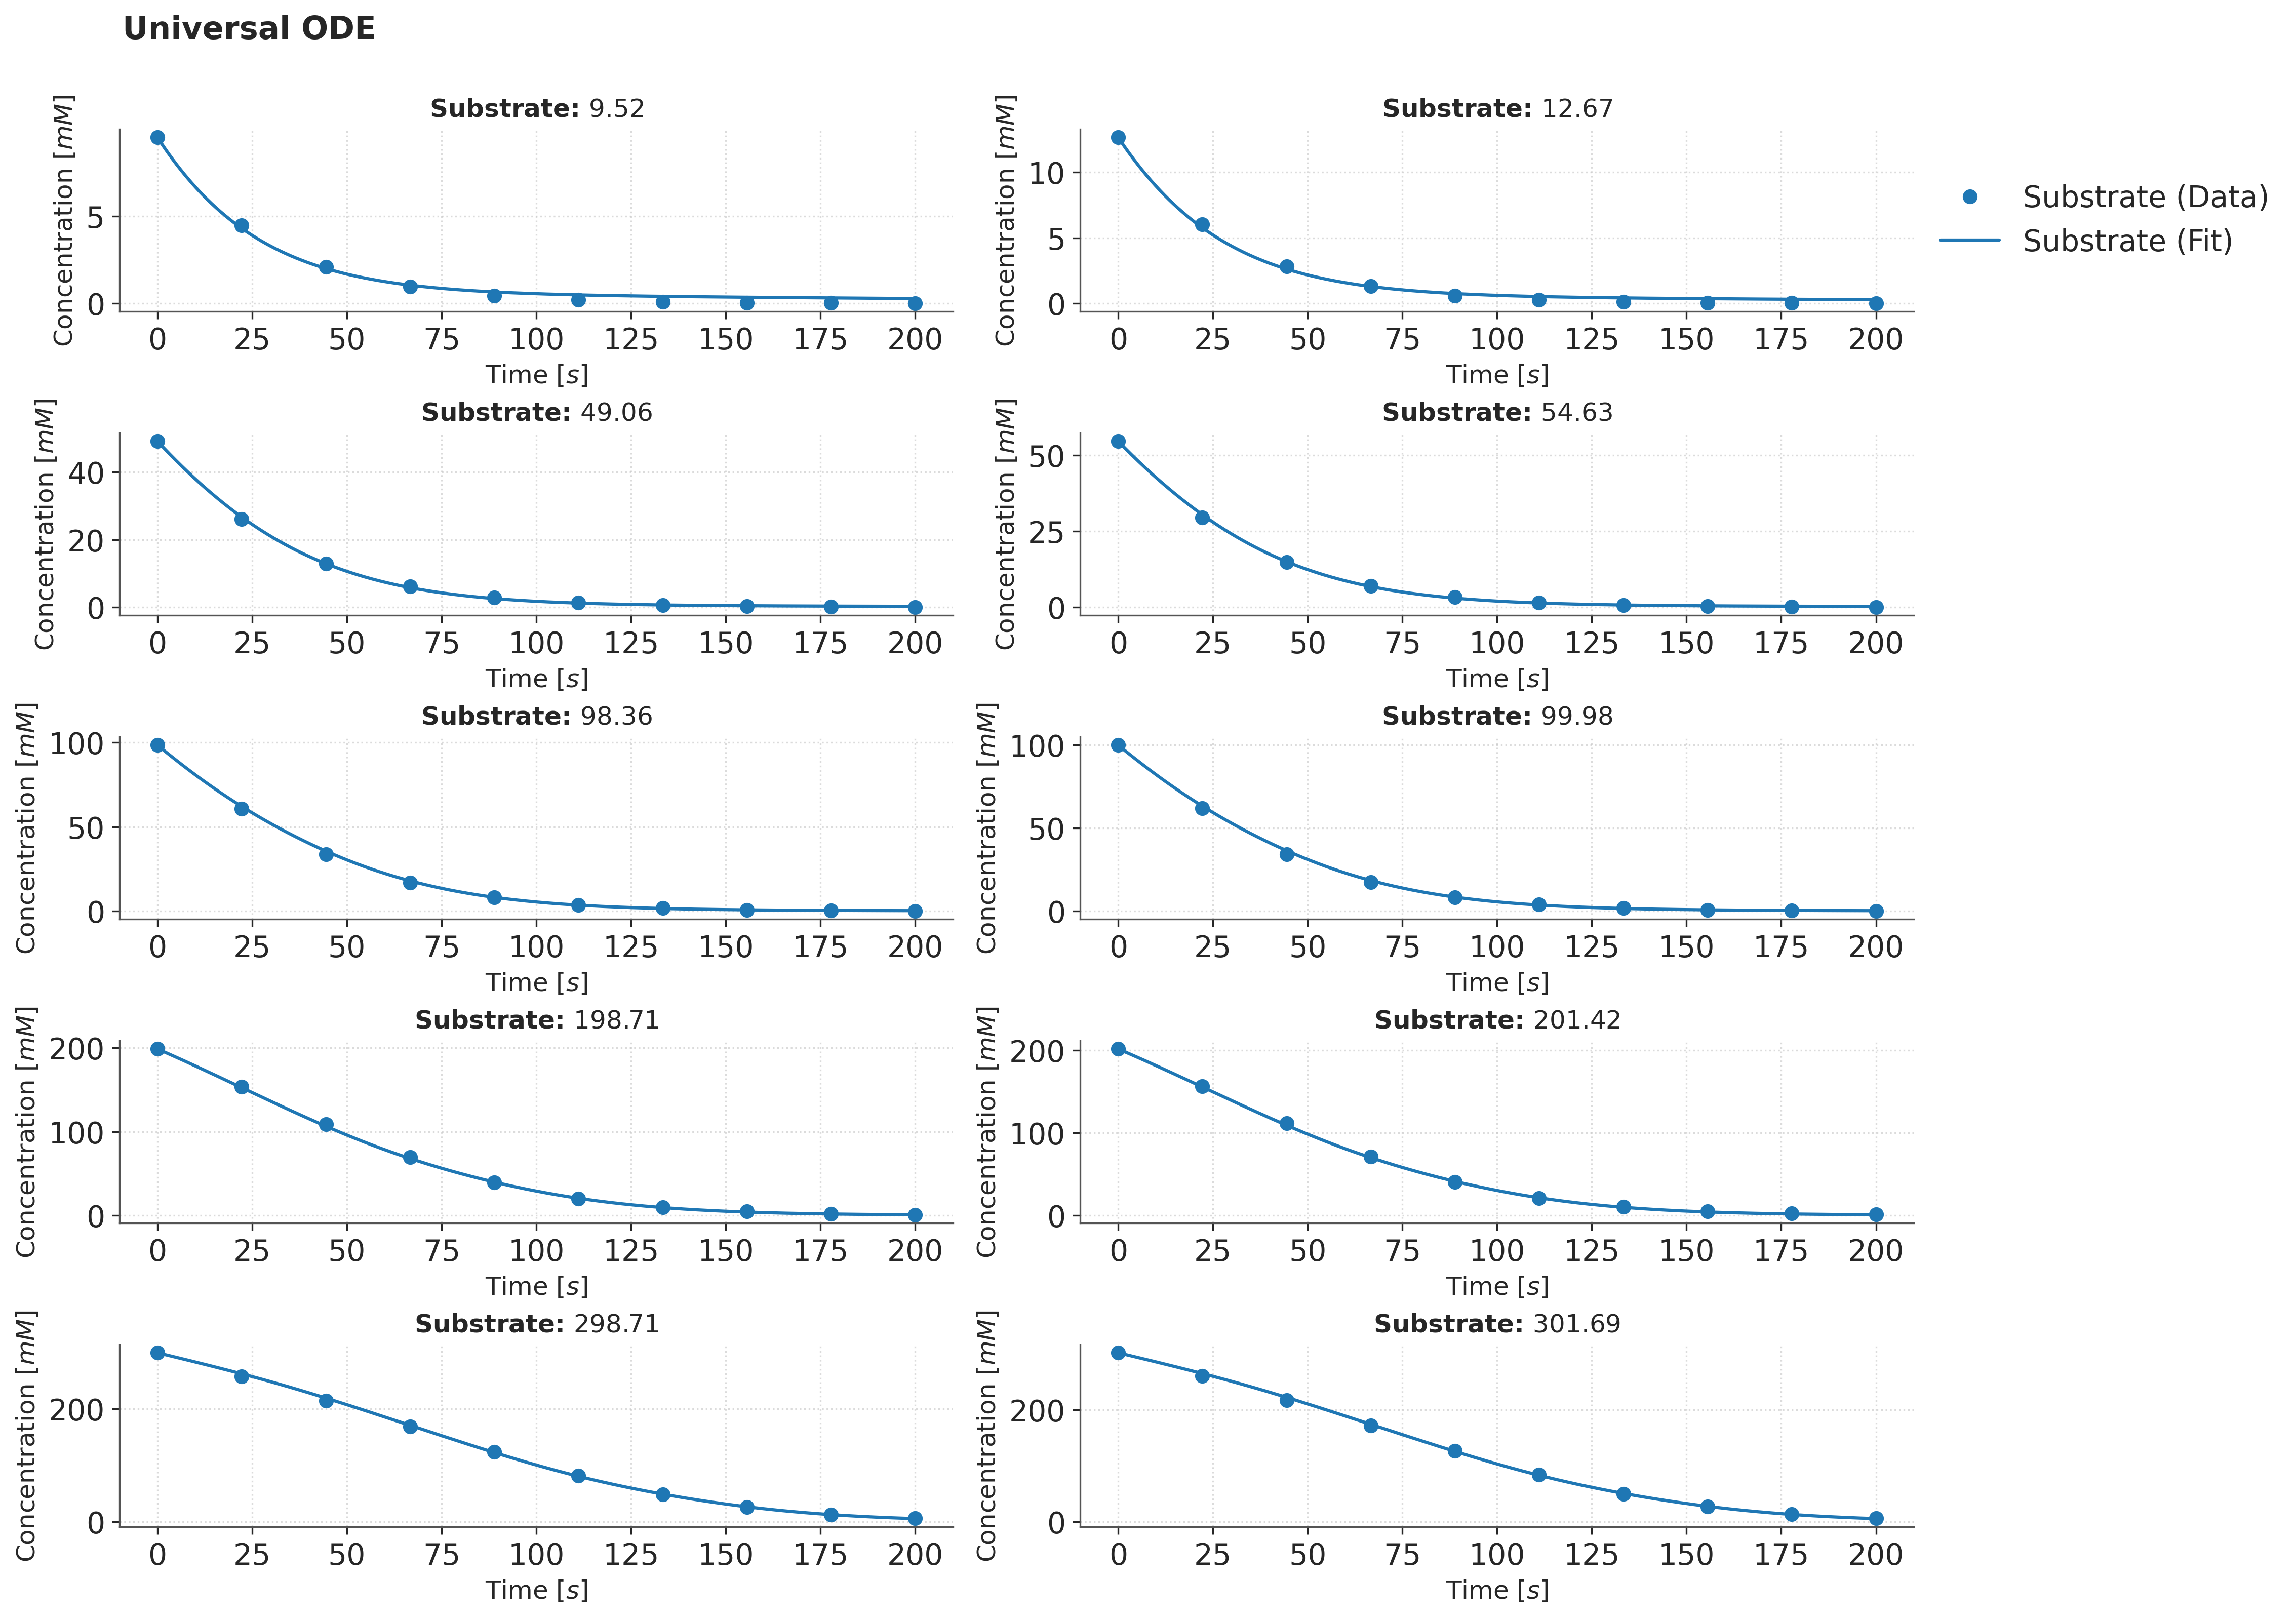

In [8]:
f = ctx.visualize(
    model=model,
    data=states,
    neural_ode=trained,
    times=jnp.stack([time] * len(initial_conditions), axis=0),
    initial_conditions=initial_conditions,
    figsize=(3, 5),
    title="Universal ODE",
)

Now we are investigating the correction of the neural network over time. We will plot the neural network correction over time and hope to identify a pattern that gives us an indication how to fix the model.

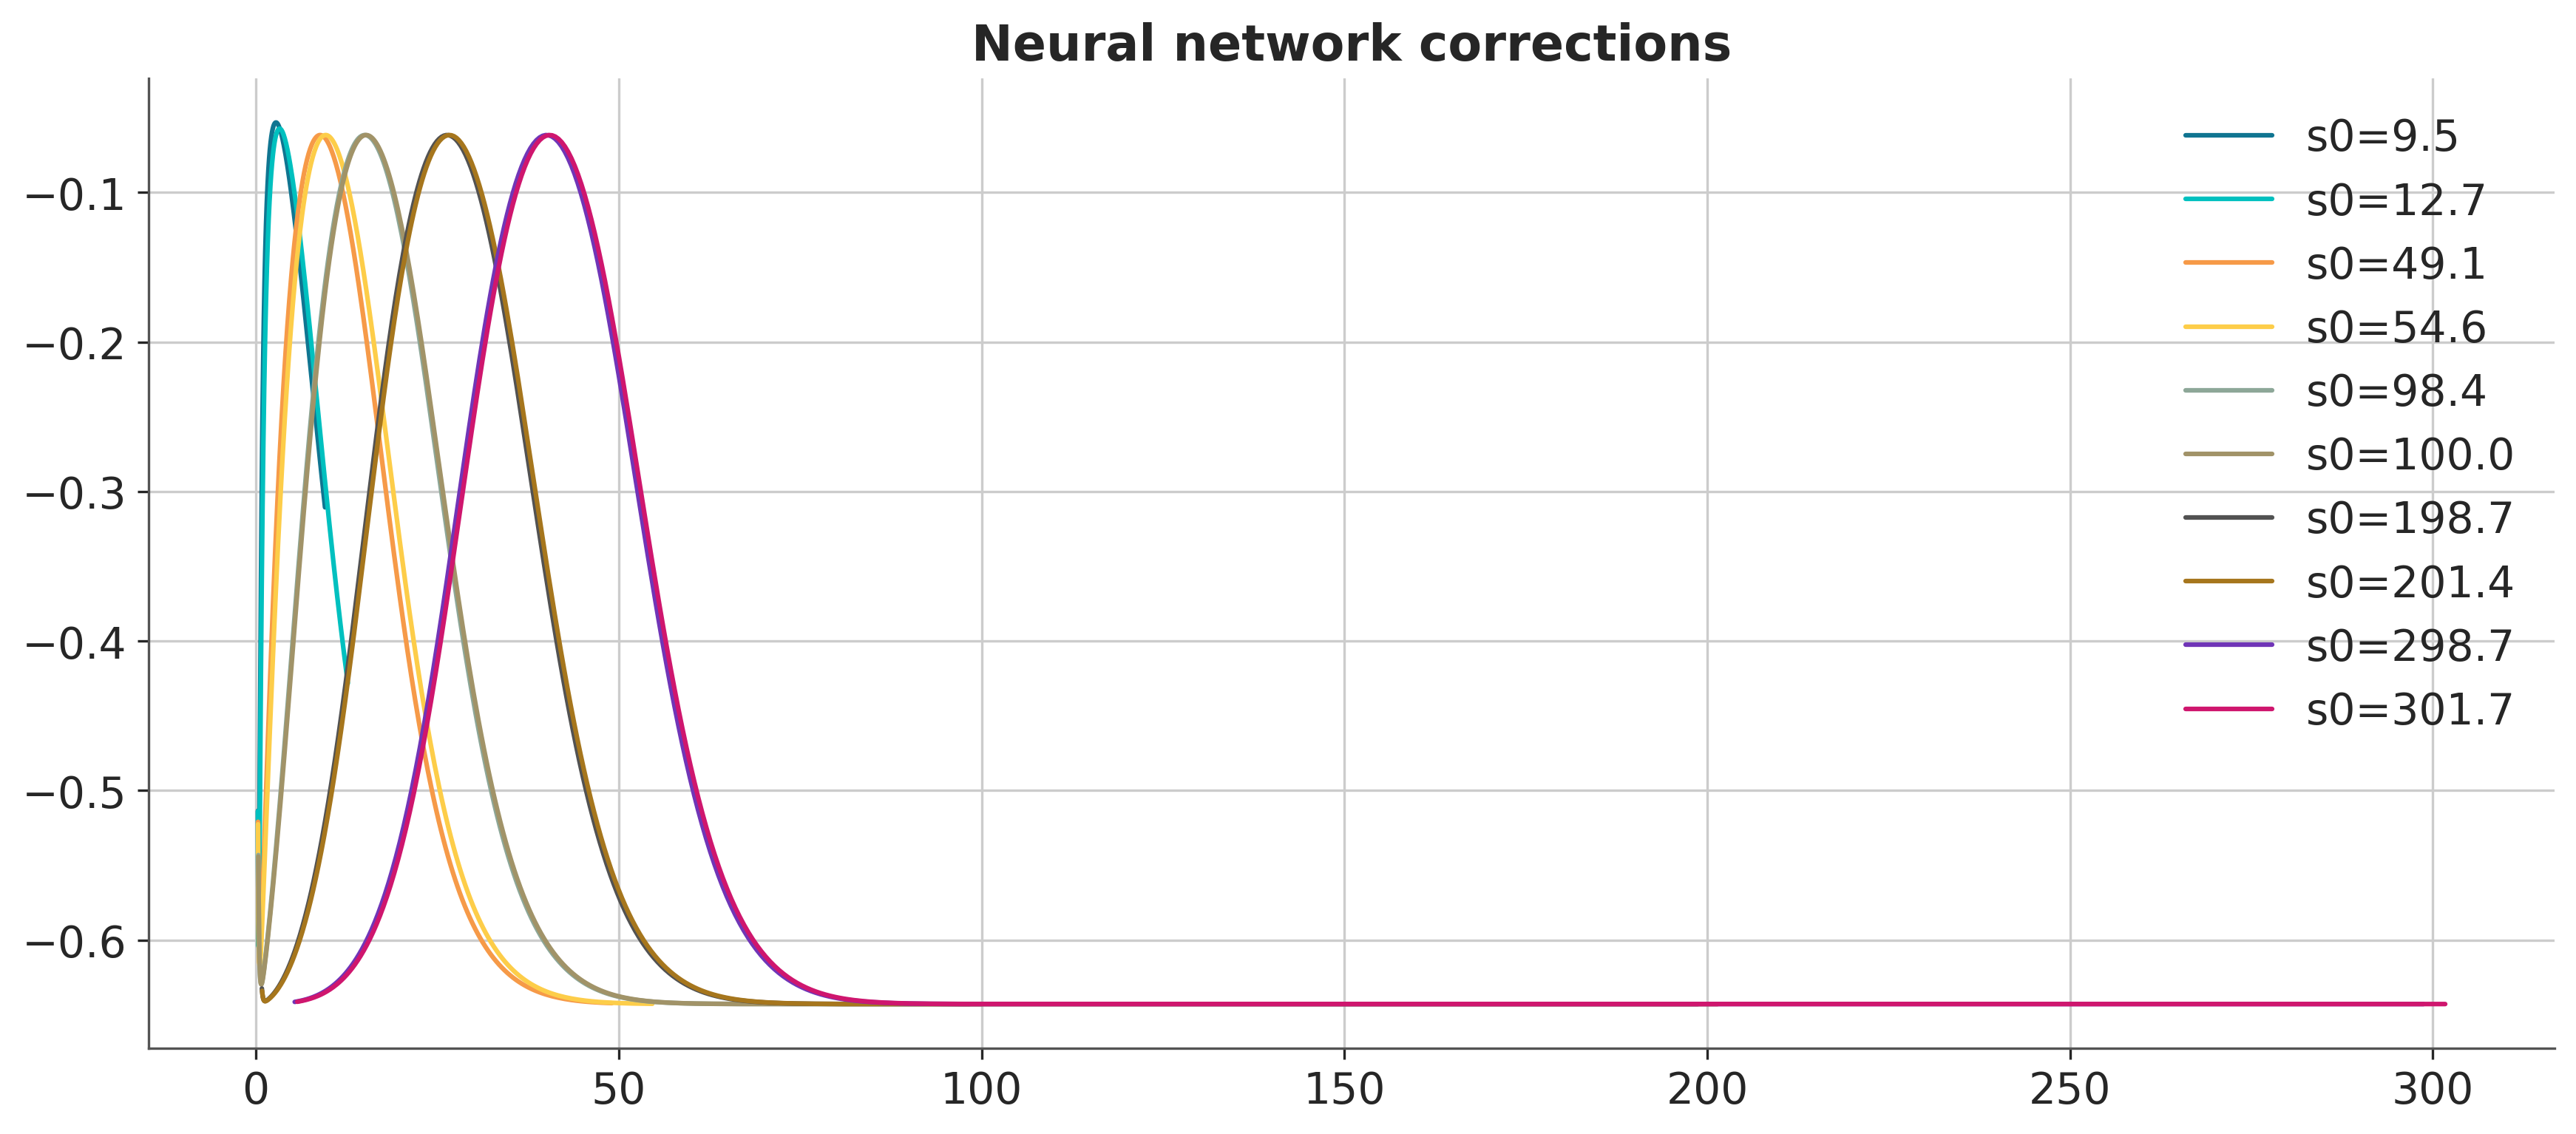

In [9]:
# Use the universal ODE to predict trajectories
time_uode, states_uode = trained.predict(y0s=y0s, t0=0.0, t1=200.0, nsteps=500)

# Prepare inputs for the neural network
X = jnp.concatenate(
    [jnp.expand_dims(time_uode, -1), states_uode],
    axis=-1,
).reshape(-1, 2)

# Evaluate the neural network
nreps, ntime, _ = states_uode.shape
y_pred = jax.vmap(trained.func.mlp)(X)
corrections = y_pred.reshape(nreps, ntime, 1)

# Visualize the results
for index, initial_condition in enumerate(initial_conditions):
    plt.plot(
        states_uode[index, :, 0],
        corrections[index, :, 0],
        label=f"s0={initial_condition['s0']:.1f}",
    )

plt.title("Neural network corrections")
plt.legend()
plt.grid()

## Conclusion

We observe that the universal ODE is capable of correcting the dynamics of the system in low substrate concentrations. Thus, it is a great tool to close the gap and provide a more accurate prediction. When investigating the corrections the neural network is introducing, it seems that the ANN is "pushing" against the dynamics of the Michaelis-Menten model. This might be an indication, that some kind of competitive substrate inhibition is going on in the system.

From this point on, the analysis could have been continued with symbolic regression to find novel terms from the neural network that may help to conclude a new model from theory or by directly employing the found equations. However, this is not the scope of this notebook.